* ! pip install tensorflow
* ! pip install Pillow
* ! pip install matplotlib
* ! pip install opencv-python
* ! pip install scikit-learn

In [15]:
import numpy as np
import cv2
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import *


from PIL import Image
import glob

import matplotlib.pyplot as plt


In [16]:
## Cargar el conjunto de datos MIAS
# Nota: Asegúrate de adaptar la función de carga según tu necesidad y estructura de datos
def load_mias_data(directory='data/data/mias-mammography/all-mias-roi'):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.pgm'):  # Asume que las imágenes están en formato .pgm, cambia según corresponda
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))  # Cambia el tamaño de la imagen si es necesario

            images.append(img)

            # Aquí puedes añadir etiquetas si las tienes. Por ahora, solo añadiré 0 como etiqueta ficticia
            labels.append(0)

    return (np.array(images), np.array(labels)), (None, None)  # Retorna imágenes y etiquetas, y por ahora 'None' para el conjunto de validación

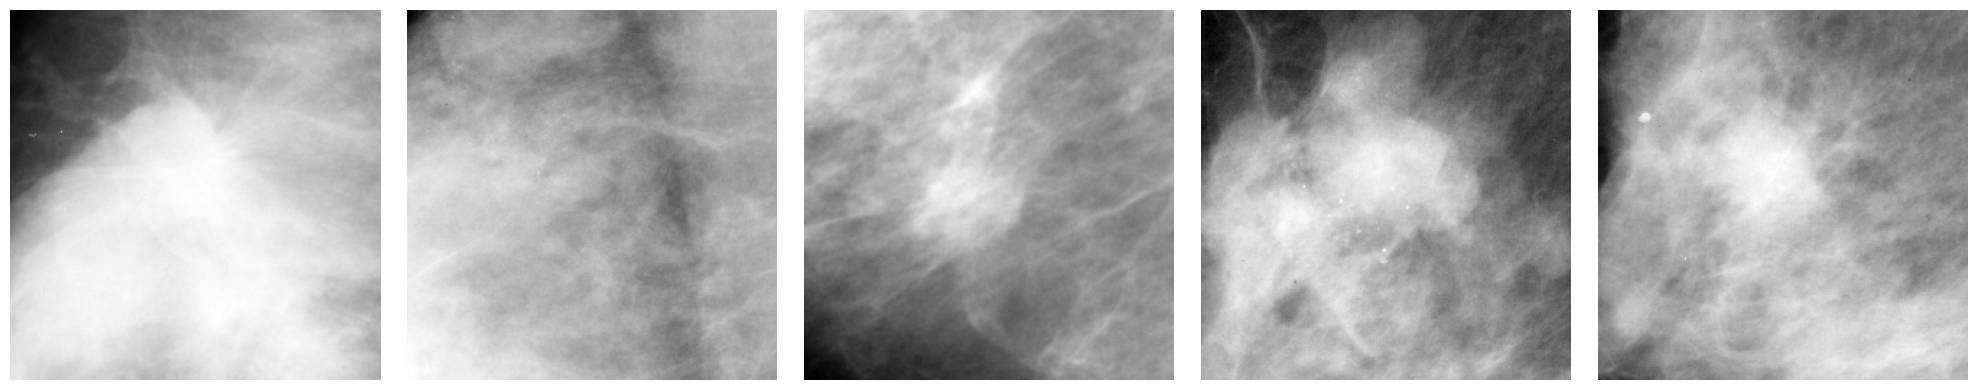

In [17]:
def visualize_random_images(images, num_images=5):
    selected_images = random.sample(list(images), num_images)
    
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Cargar las imágenes
(x_train, _), _ = load_mias_data()

# Visualizar 10 imágenes aleatorias
visualize_random_images(x_train)

In [18]:
(x_train, _), (_, _) = load_mias_data()
x_train = x_train.astype('float32') / 255.0

In [19]:
# Definir el modelo generador
def generator():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(128,)),
            layers.Dense(256, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(512, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(1024, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256 * 256, activation="softmax"),
            layers.Reshape((256, 256)),
        ]
    )
    return model

In [20]:
# Definir el modelo generador
#def generator():
#    base_Neural_Net=MobileNetV2(input_shape=(256, ), weights='imagenet', include_top=False)
#    model=keras.Sequential(
#       [ 
#          layers.Dense(input_shape=(128,)),
#          layers.Flatten(),
#          layers.BatchNormalization(),
#          layers.Dense(256 ,kernel_initializer='he_uniform'),
#          layers.BatchNormalization(),
#          layers.Activation('relu'),
#          layers.Dropout(0.5),
#          layers.Dense(256 * 256, activation='softmax'),
#          layers.Reshape((256, 256)),
 #      ]
 #   )
#    return model

In [21]:
# Definir el modelo discriminador
def discriminator():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(256, 256)),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(1, activation="softmax"),
        ]
    )
    return model

In [22]:
# Instanciar y compilar modelos
generator = generator()
discriminator = discriminator()

In [23]:
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [24]:
z = layers.Input(shape=(128,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

In [25]:
combined = keras.Model(z, validity)
combined.compile(optimizer="adam", loss="binary_crossentropy")

In [26]:
# Entrenar la GAN
def train(epochs, batch_size=128):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 128))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 128))
        g_loss = combined.train_on_batch(noise, valid)

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")


In [27]:
# Entrenar la GAN
train(epochs=100, batch_size=128)

4/4 [==============================] - 0s 57ms/step
0/100 [D loss: 0.8374152481555939 | D accuracy: 0.5] [G loss: 0.6825128197669983]
4/4 [==============================] - 0s 83ms/step
1/100 [D loss: 1.034570723772049 | D accuracy: 0.5] [G loss: 0.5246816873550415]
4/4 [==============================] - 0s 66ms/step
2/100 [D loss: 0.8946811556816101 | D accuracy: 0.5] [G loss: 0.521405816078186]
4/4 [==============================] - 0s 68ms/step
3/100 [D loss: 0.8505054712295532 | D accuracy: 0.5] [G loss: 0.6321736574172974]
4/4 [==============================] - 0s 79ms/step
4/100 [D loss: 0.9094760119915009 | D accuracy: 0.5] [G loss: 0.6628304719924927]
4/4 [==============================] - 0s 71ms/step
5/100 [D loss: 0.8443175256252289 | D accuracy: 0.5] [G loss: 0.6900240182876587]
4/4 [==============================] - 0s 73ms/step
6/100 [D loss: 0.8665241897106171 | D accuracy: 0.5] [G loss: 0.6090174317359924]
4/4 [==============================] - 0s 68ms/step
7/100 [D los

1/1 [==============================] - 0s 258ms/step


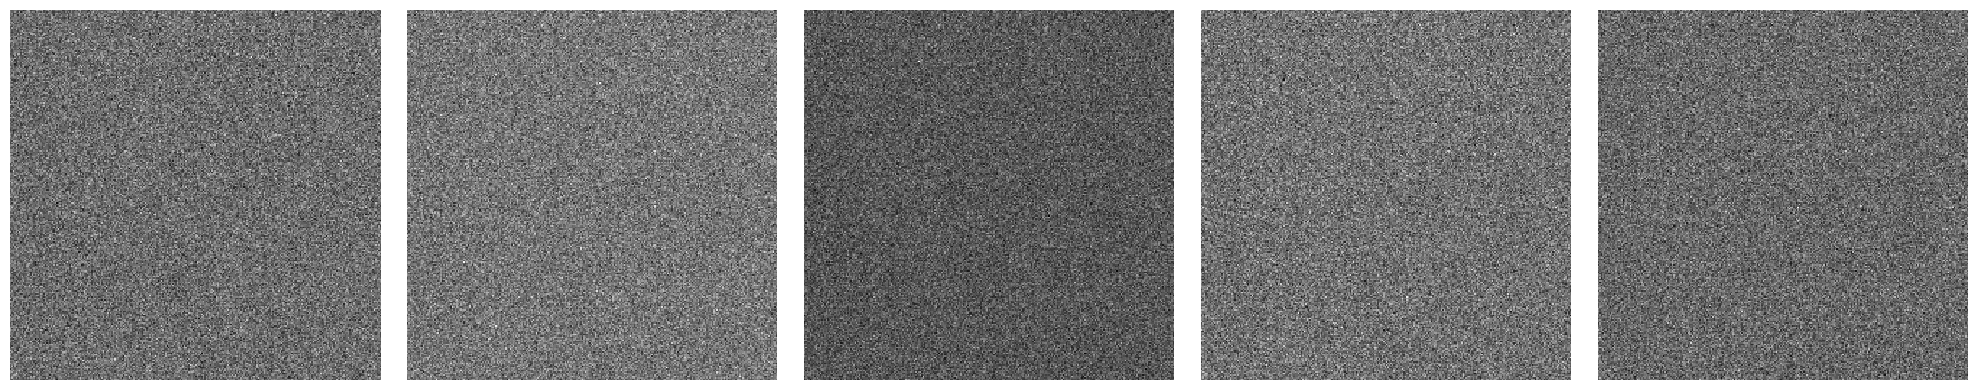

In [28]:
def generate_and_visualize_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 128))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Genera y visualiza 10 imágenes después de entrenar la GAN
generate_and_visualize_images(generator, num_images=5)